# Lecture 15 on October 20, 2022 from Professor Konstantin Matchev's  Fall 2022 PHY7097 Machine Learning Course. 

Professor Website: http://www.phys.ufl.edu/~matchev/

# Novelty and Outlier Detection: the Basics

As scientists we are often faced with the question whether a given observation belongs to the same distribution as the existing observations (an **inlier**) or should be considered as different (an **outlier**). This is important for cleaning the data, claiming a discovery, etc.
*   **Outlier detection**: The training data already contains outliers, i.e., observations far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations. In the context of outlier detection, the outliers/anomalies cannot form a dense cluster as available estimators assume that the outliers/anomalies are located in low density regions.
*   **Novelty detection**: The training data is not polluted by outliers and we must decide whether a **new** observation is an outlier. Particle physics example: the training data is from a Standard Model Monte Carlo and we must decide whether an unusual event is due to new physics (novelty) or not.

Outliers can have many causes, such as:

* Measurement or input error.
* Data corruption.
* True outlier observation (e.g. Michael Jordan in basketball).

Outlier detection methods alert you to anomalous instances in the data, but do not tell you what to do afterwards (how to handle them), this is completely up to you.

## Comparing five anomaly detection algorithms for outlier detection on five toy datasets

Let's compare the performance of five different anomaly detection algorithms on five toy datasets. In each dataset, 15% of the points are generated as random uniform noise. The remaining 85% of the points are generated as
1.   A single medium-sized cluster at the origin.
2.   Two medium-sized clusters at (-2,-2) and (+2,+2).
3.   One large sparse cluster at (+2,+2) and one small dense cluster at (-2,-2).
4.   Two moons.
5.   A uniform distribution.

These datasets are illustrated in the plots below.



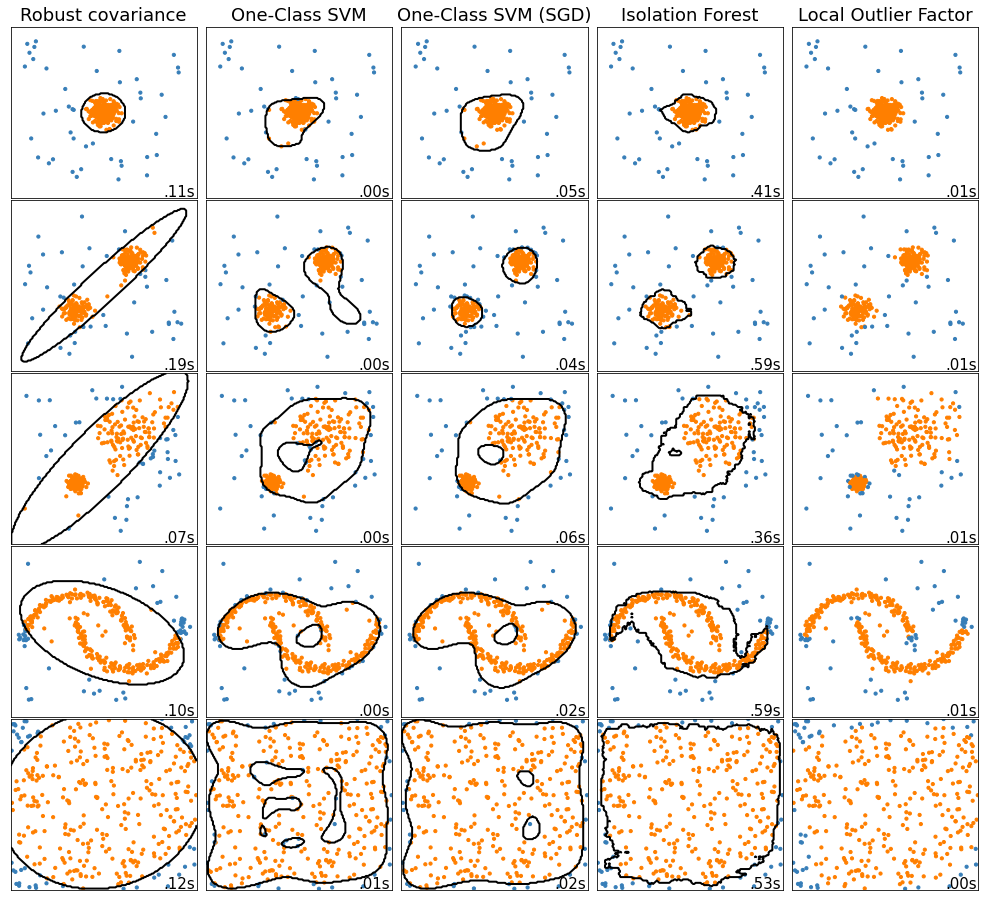

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred +1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

Each of the five datasets is processed with each of the following five outlier detection algorithms:
1.   **Robust Covariance**: This method is also known as **Fast-MCD (minimum covariance determinant)** or **Elliptic Envelope** and is implemented through the *sklearn.covariance.EllipticEnvelope* class. It is useful for outlier detection, and in particular for cleaning up the dataset. It is an example of **model-based learning**: it assumes that the normal instances (the inliers) are generated from a single Gaussian distribution (not a Gaussian mixture - this is why the performance of this algorithm degrades when the data is not unimodal), and that the data is further contaminated with outliers which do not follow this Gaussian distribution. When the model tries to fit for the parameters of the Gaussian distribution, it is careful to ignore the instances which are most likely outliers --- this means that this estimator is robust to outliers. 
2.   **One-Class SVM**: Recall that in our SVM lecture we learned how to separate two classes by first (implicitly) mapping all the instances to a higher-dimensional space, then separating the two classes by choosing a flat hyperplane within this high-dimensional space. In the context of anomaly detection, we have only one class, so the **one-class SVM** algorithm instead tries to separate the instances in this high-dimensional space from the origin. In the original space, this will correspond to finding a region that tightly encompasses most of the instances - any instances outside that region would be labelled as anomalies (see pictures above). There are a few parameters to tweak - the usual ones for a kernelized SVM, plus a margin hyperparameter $\nu$ that sets an upper bound on the fraction of outliers (in the example above it was set to 0.15, but feel free to change it and see what happens). Due to the importance of this parameter, this method is often referred to as **$\nu$-SVM**. Because the algorithm targets the bulk of the points, it is well suited for novelty detection.
3.   **One-Class SVM (SGD)**: the Stochastic Gradient Descent (SGD) version of the previous algorithm.
4.   **Isolation forest**: This is an efficient algorithm for outlier detection, especially in high-dimensional datasets. The algorithm builds a random forest in which each tree is grown randomly: pick a feature at random, then pick a random threshold value between the min and the max of that feature. This continues until all instances end up isolated from all other instances. Anomalies are usually far away from other instances, and therefore they tend to get isolated in fewer staps than normal instances:

<img width=500 src="https://miro.medium.com/max/4800/1*s_L43ROWfkp9DuY8ib6Www.png">

However, there is also a disadvantage with isolation forests. Edge points that are normal are also easy to isolate. These points have a chance to be classified as outliers, while they are normal. Keep this in mind when using this technique.

5.   **Local Outlier Factor**: this is a technique that leverages the idea of nearest neighbors for outlier detection through density estimation. It compares the density around a given instance to the density around its neighbors. An anomaly is often more isolated than its neighbors. Each example is assigned a scoring of how isolated it is (and therefore how likely it is to be an outlier); those examples with the largest scores are more likely to be outliers. See explicit example below.





## Anomaly detection using Gaussian mixtures

As a generalization of the Fast-MCD method, we can consider a Gaussian mixture model, where we first fit the data with a collection of Gaussians, and then declare any instance which ends up in a low density region as an anomaly. It is up to us to decide what density threshold we want to use. Also, just like K-Means, the GaussianMixture algorithm requires us to specify the number of clusters ahead of time. 

First create some data and plot it:

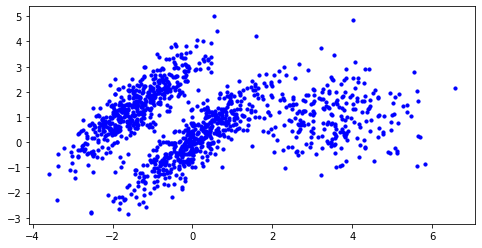

In [2]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plt.figure(figsize=(8, 4))

plt.scatter(X[:, 0],X[:, 1],color='b',marker='o',s=10)

plt.show()

In [3]:
X1.shape

(1000, 2)

In [4]:
X2.shape

(250, 2)

In [5]:
X.shape

(1250, 2)

Now train a Gaussian Mixture Model on it. Let's cheat and specify three components (the correct number):

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Now select the anomaly threshold as 4% and categorize the points:

In [7]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [8]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

This plot shows the decision boundaries, the probabilities and labels the anomalous points as red stars.

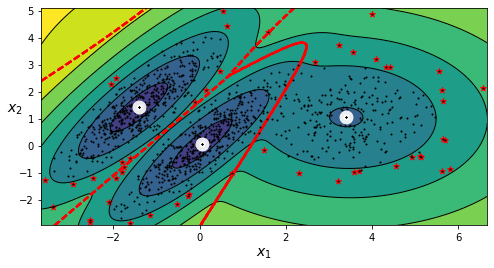

In [9]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

## Anomaly detection using DBSCAN 

The DBSCAN clustering algorithm naturally finds instances which cannot be associated with any cluster and are therefore labelled as anomalies. Below is the demo from scikit-learn.

In [10]:
%matplotlib inline

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Generate sample data



In [11]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

Compute DBSCAN



In [12]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


Plot result. The black points are identified as noise (anomalies).



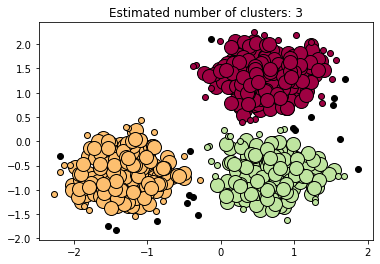

In [13]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## Anomaly detection using Local Outlier Factor

From the User Guide:

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. This example shows how to use LOF for outlier detection which is the default use case of this estimator in scikit-learn. 

The number of neighbors considered (parameter n_neighbors) is typically set 1) greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster, and 2) smaller than the maximum number of closeby samples that can potentially be local outliers. In practice, such information is generally not available, and taking n_neighbors=20 appears to work well in general (check what happens if you change the default value).

The anomaly scores are min-max normalized and indicated by the radius of each red circle.

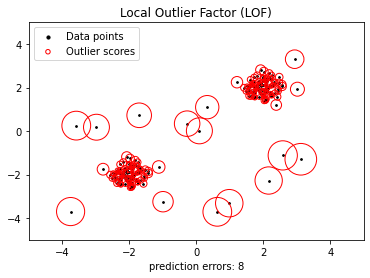

In [14]:

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()